**Name**

* **Yu-Chih (Wisdom) Chen**
* **Devon Delgado**
* **Xiaobing Xu**
* **Peter Ye**

**Date**

**11/16/2024**

# Fake Job Description Prediction Dataset

## Overview
This dataset is designed for developing classification models to identify fraudulent job postings. It contains approximately 18,000 job descriptions, with around 800 labeled as fake.

## Dataset Details
- **Total Entries**: ~18,000 job descriptions
- **Fraudulent Entries**: ~800
- **Data Types**: Textual information and meta-information about jobs

## Source
The University of the Aegean | Laboratory of Information & Communication Systems Security
(http://emscad.samos.aegean.gr/)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from feast import FeatureStore
from nltk.tokenize import word_tokenize  
from pandarallel import pandarallel
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

!python3 -m spacy download en_core_web_sm
from utli import *

## 1. Load Data

In [29]:
df = pd.read_csv('fake_job_postings.csv') # Change it to data source

In [30]:
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


## 2. Exploratory Data Analysis (EDA)

In [31]:
# Get the dimensions of the Dataset
print("Dimensions of the Dataset (Rows, Columns):")
df.shape

Dimensions of the Dataset (Rows, Columns):


(17880, 18)

In [32]:
# Removing any leading, and trailing whitespaces in columns
df.columns = df.columns.str.strip()

In [33]:
# Check if any duplicate rows in dataset
df.duplicated().sum()

0

In [34]:
# Getting an overview of the features and their types in the dataset
print("Overview of the features and their types:")
df.info()

Overview of the features and their types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15184 non-null  object
 8   benefits             10668 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry   

In [35]:
# Count the number of columns with dtype 'object'
object_cols = df.select_dtypes(include=['object']).columns
num_object_cols = len(object_cols)

# Count the number of columns with dtype 'int64'
int_cols = df.select_dtypes(include=['int64']).columns
num_int_cols = len(int_cols)

print(f"Number of columns with object dtype: {num_object_cols}")
print(f"Number of columns with int64 dtype: {num_int_cols}")

Number of columns with object dtype: 13
Number of columns with int64 dtype: 5


### a. Missing Values

In [36]:
print("Display Missing values in the dataset: ")
print("\n")

print(df.isnull().sum())

Display Missing values in the dataset: 


job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2696
benefits                7212
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64


In [37]:
# View percentage of missing values per column
print('Percent of Null Values in Each Column:\n')
print(df.isnull().sum()/df.shape[0]*100)

Percent of Null Values in Each Column:

job_id                  0.000000
title                   0.000000
location                1.935123
department             64.580537
salary_range           83.959732
company_profile        18.501119
description             0.005593
requirements           15.078300
benefits               40.335570
telecommuting           0.000000
has_company_logo        0.000000
has_questions           0.000000
employment_type        19.412752
required_experience    39.429530
required_education     45.329978
industry               27.421700
function               36.101790
fraudulent              0.000000
dtype: float64


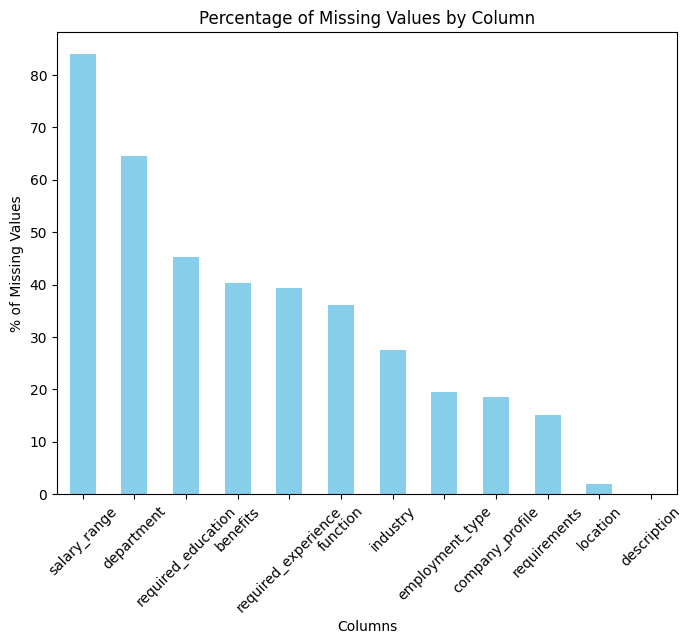

In [38]:
# Count and display percentage of missing values
missing_percent = (df.isnull().sum() / len(df)) * 100
missing_percent = missing_percent[missing_percent > 0].sort_values(ascending=False)

plt.figure(figsize=(8, 6))
missing_percent.plot(kind='bar', color='skyblue')
plt.title('Percentage of Missing Values by Column')
plt.ylabel('% of Missing Values')
plt.xlabel('Columns')
plt.xticks(rotation=45)
plt.show()

### b. Visualizatioin

In [39]:
#Differentiate categorical data and numerical data
df_num = df[['telecommuting','has_company_logo','has_questions','fraudulent','salary_range']]
df_cat = df[['title', 'location','company_profile', 'requirements','employment_type',
       'required_experience', 'required_education', 'industry', 'function']]

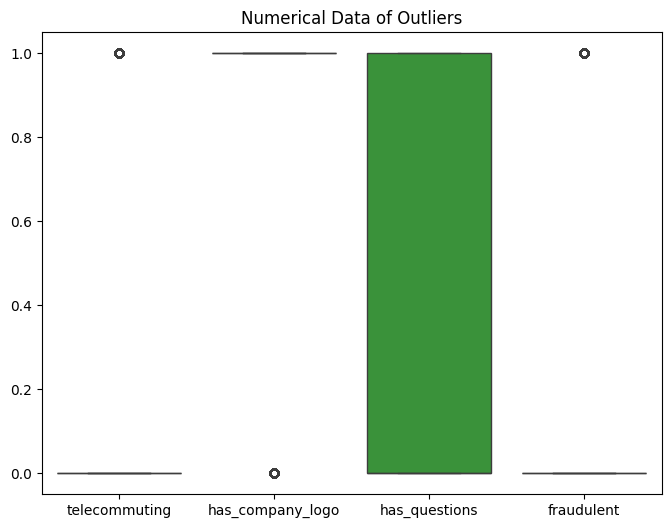

In [40]:
# Checking for Outliers in numerical data
plt.figure(figsize=[8,6])
sns.boxplot(data = df_num)
plt.title("Numerical Data of Outliers")
plt.show()

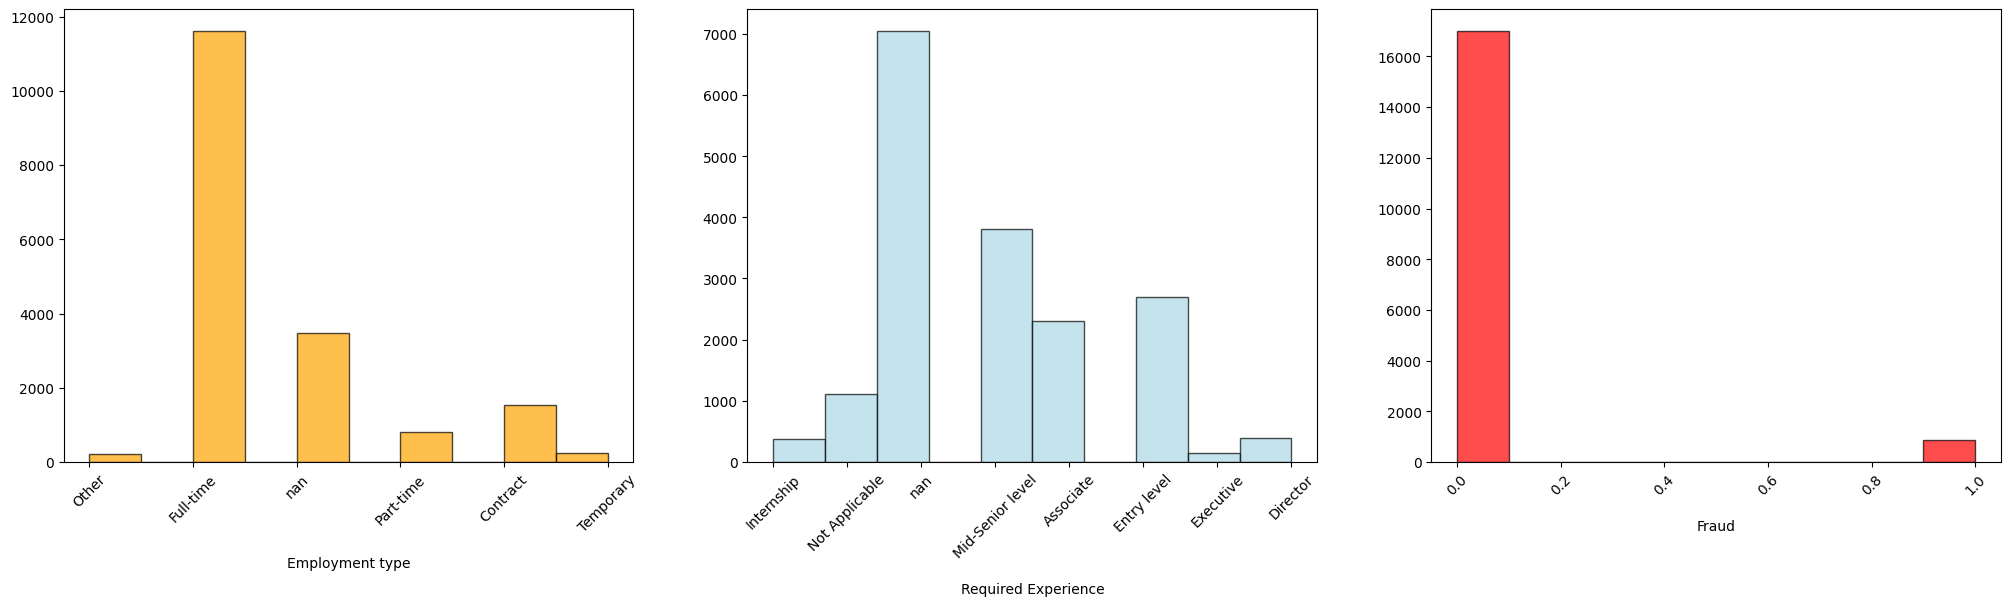

In [41]:
# Plots to see the distribution of the continuous features individually
plt.figure(figsize= (25,20))
plt.subplot(3,3,1)
# Convert 'employment_type' to string type before plotting
plt.hist(df.employment_type.astype(str), color='orange', edgecolor = 'black', alpha = 0.7)
plt.xlabel('\nEmployment type')
plt.xticks(rotation=45)

plt.subplot(3,3,2)
# Convert 'required_experience' to string type before plotting
plt.hist(df.required_experience.astype(str), color='lightblue', edgecolor = 'black', alpha = 0.7)
plt.xlabel('\nRequired Experience')
plt.xticks(rotation=45)

plt.subplot(3,3,3)
plt.hist(df.fraudulent, color='red', edgecolor = 'black', alpha = 0.7)
plt.xlabel('\nFraud')
plt.xticks(rotation=45)


plt.show()

<Axes: title={'center': 'Number of Job Function'}, xlabel='function', ylabel='count'>

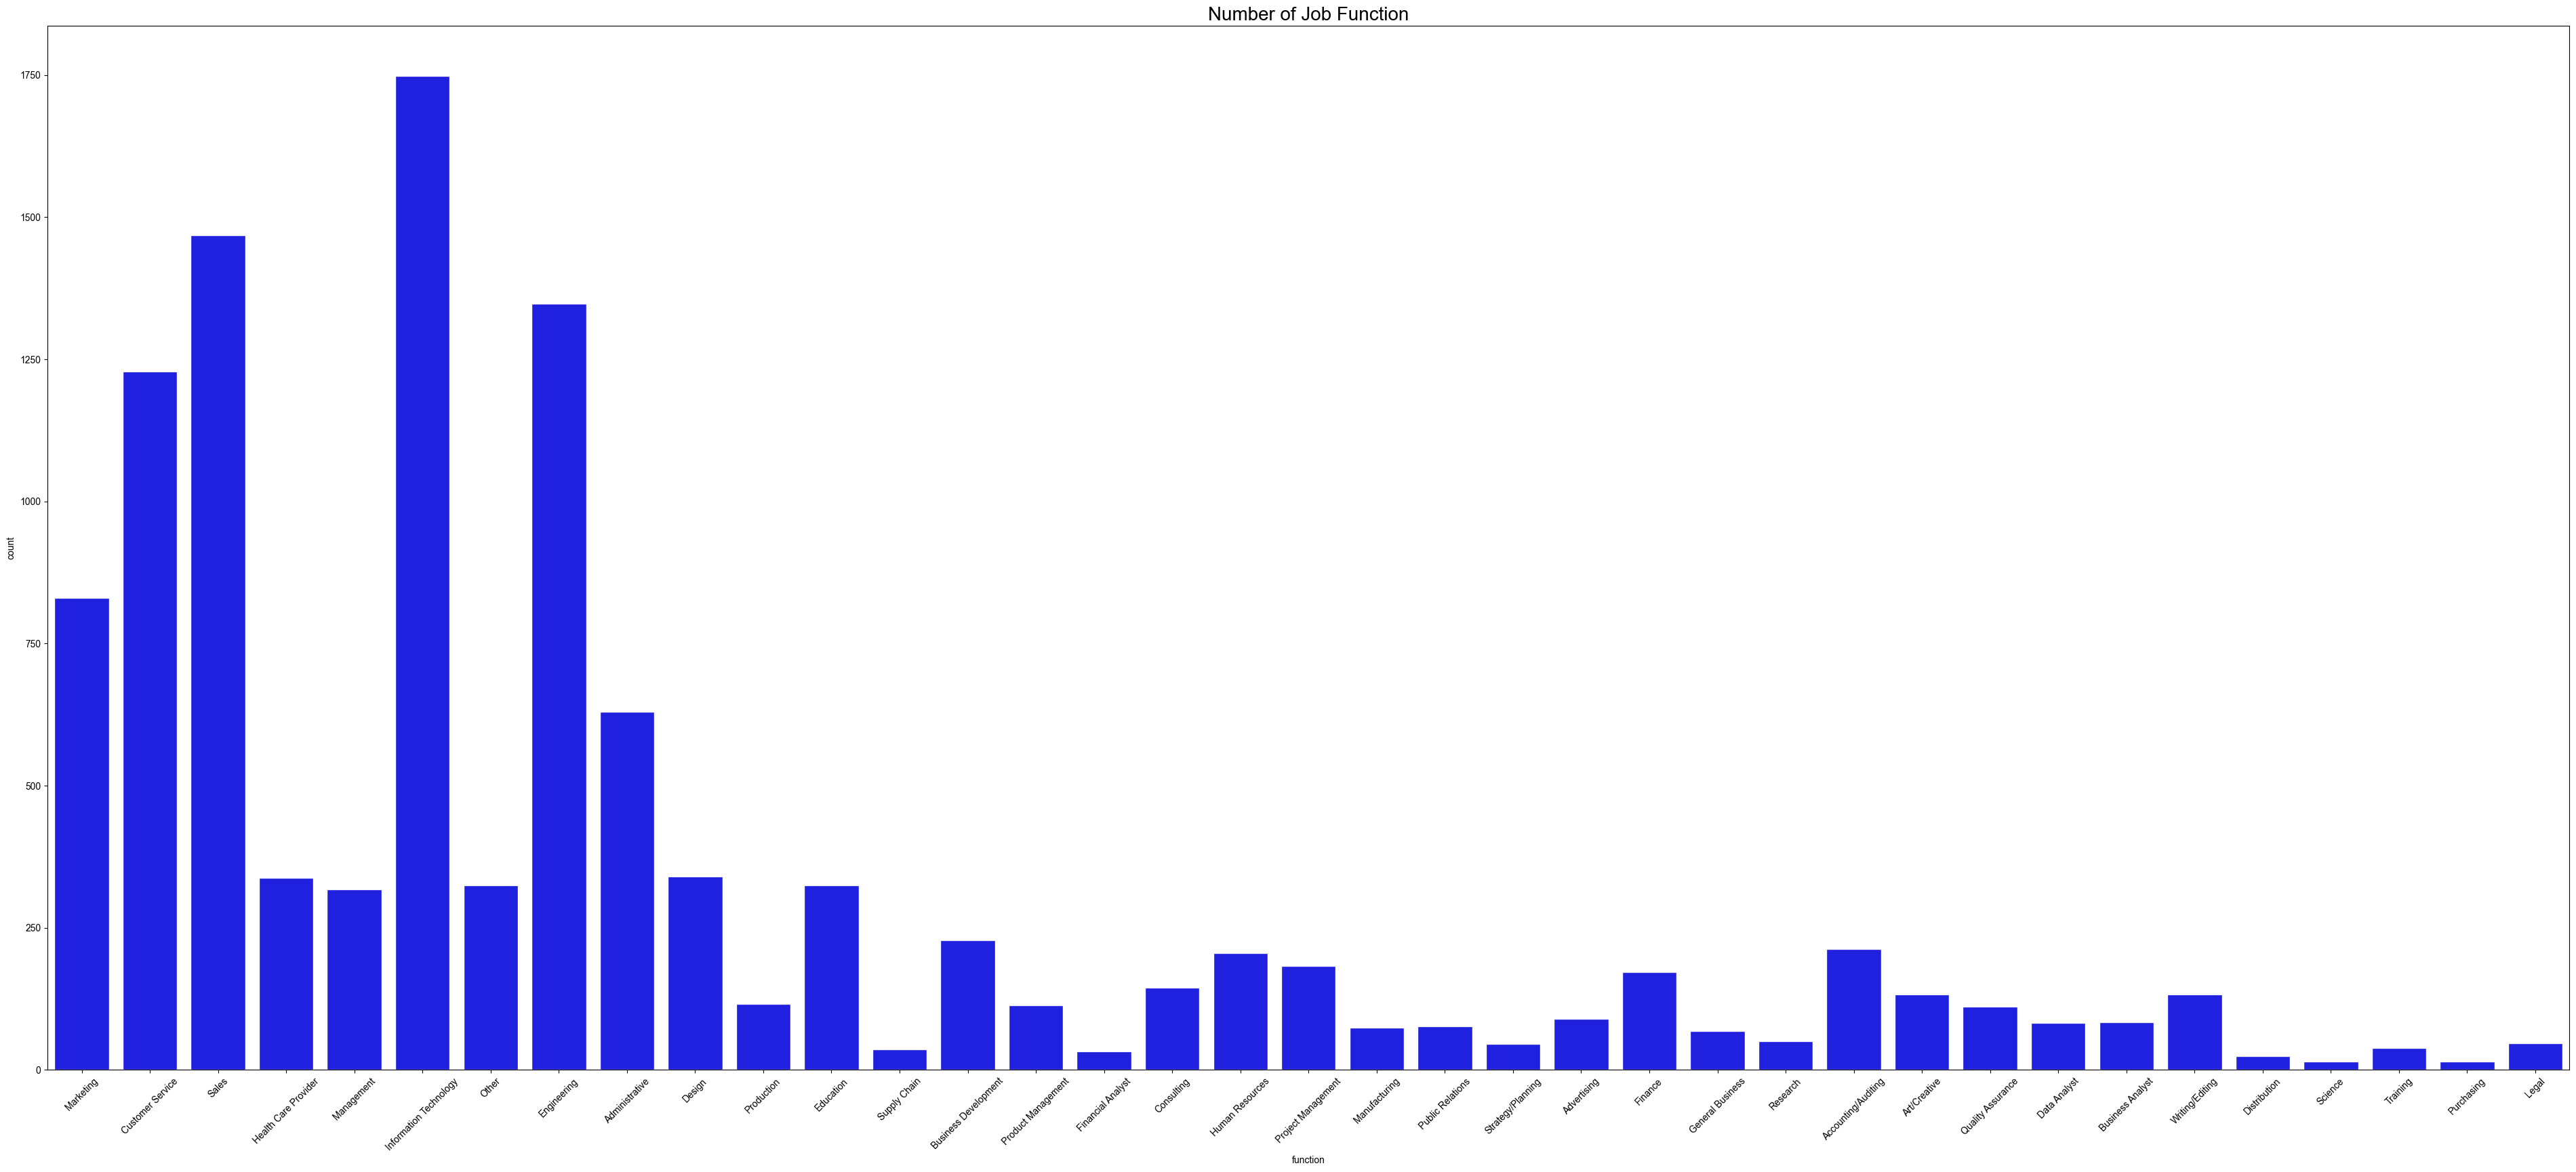

In [42]:
# Number of Job Function
plt.figure(figsize=(48, 20))
plt.xticks(rotation=45)
plt.title("Number of Job Function", fontsize=20)
sns.set_style("darkgrid")
sns.countplot(x='function', data=df, color='blue')  # Adjust color if needed

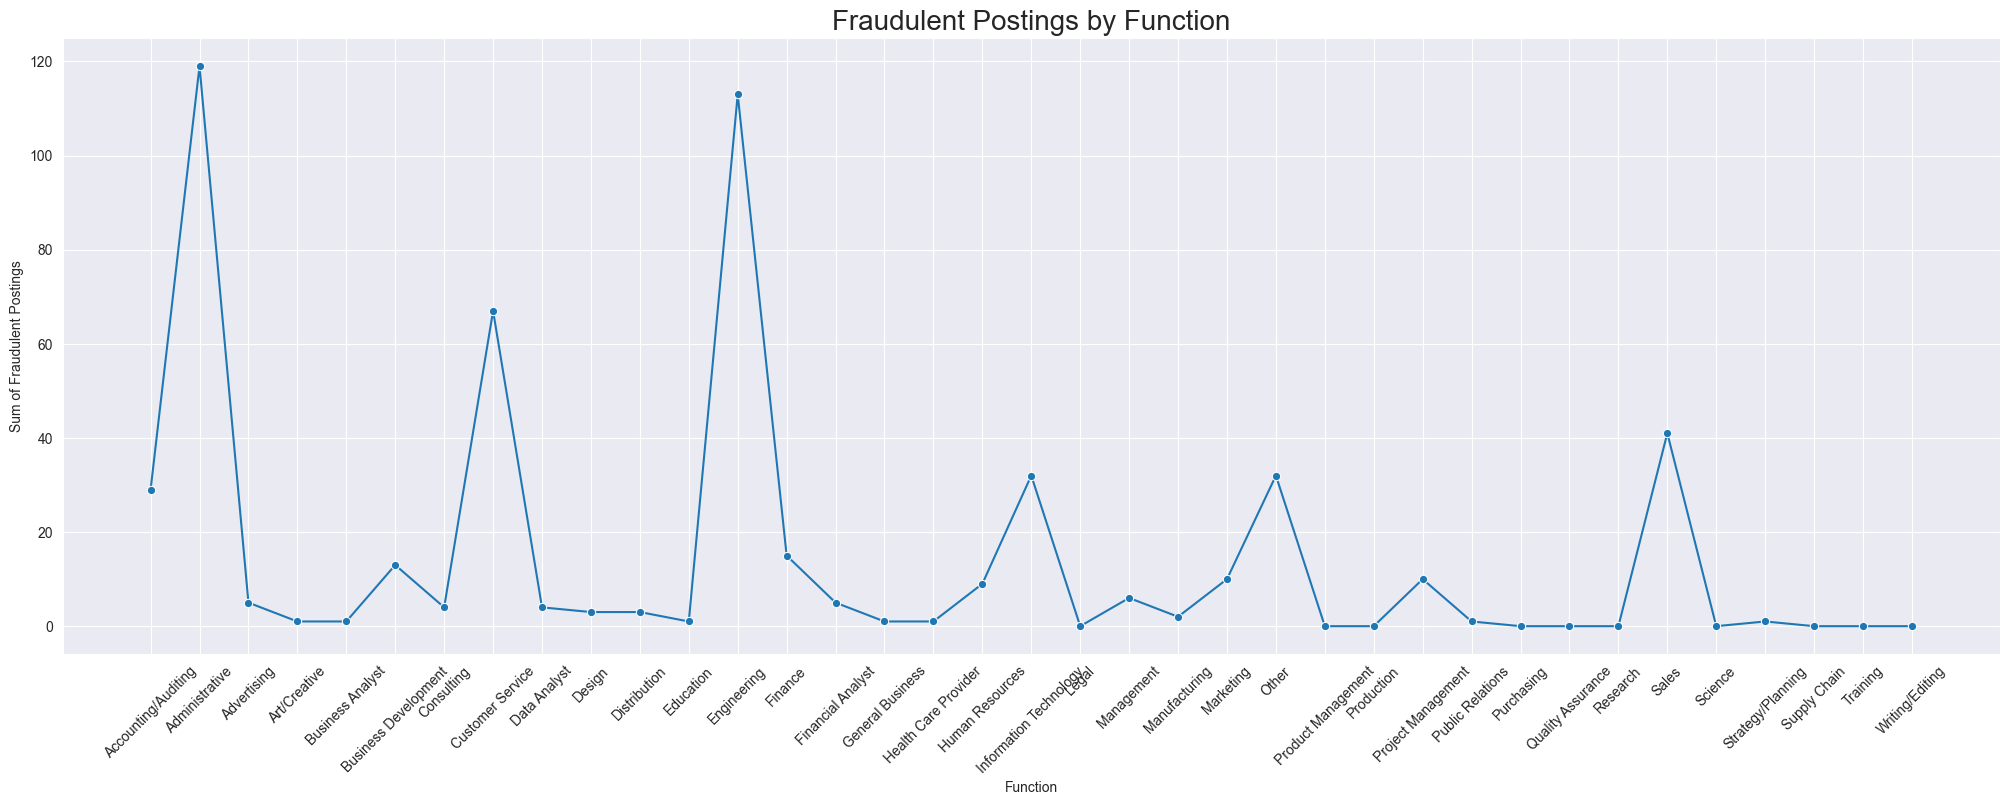

In [43]:
# Calculate the sum of fraudulent postings by function
fraudulent_summary = df.groupby('function')['fraudulent'].sum().reset_index()

plt.figure(figsize=(25, 8))
sns.lineplot(data=fraudulent_summary, x='function', y='fraudulent', marker='o')
plt.title('Fraudulent Postings by Function', fontsize = 20)
plt.xlabel('Function')
plt.ylabel('Sum of Fraudulent Postings')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

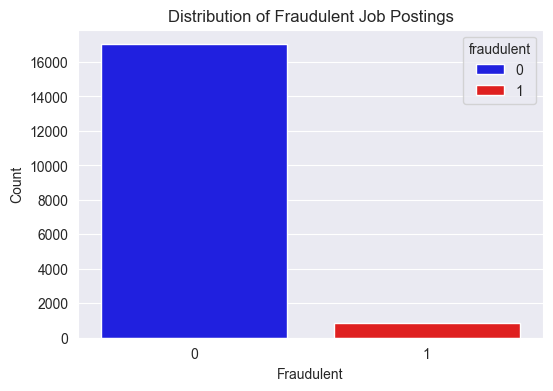

In [44]:
# Bar plot for fraudulent (target) feature
fraud_colors = ['blue', 'red']
plt.figure(figsize=(6, 4))
sns.countplot(x='fraudulent', data=df, hue='fraudulent', palette=fraud_colors, dodge=False)
plt.title('Distribution of Fraudulent Job Postings')
plt.xlabel('Fraudulent')
plt.ylabel('Count')
plt.show()

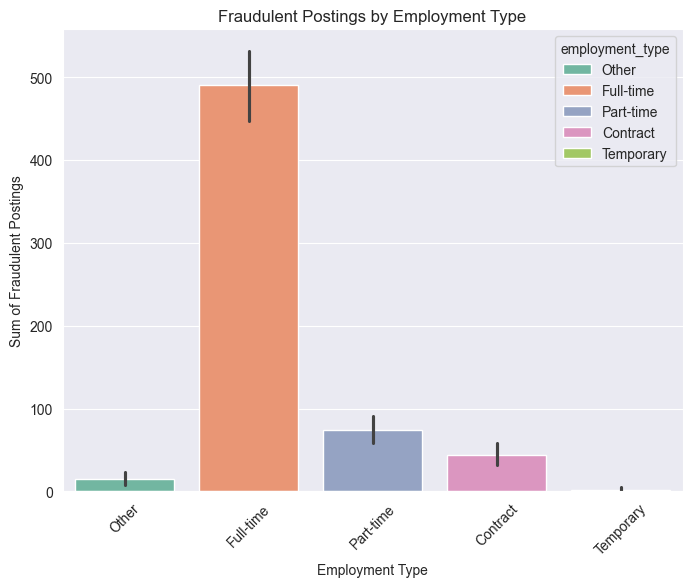

In [45]:
# Bar plot for employment_type
plt.figure(figsize=(8, 6))
sns.barplot(data=df, x='employment_type', y='fraudulent', estimator=sum, hue='employment_type', dodge=False, palette='Set2')
plt.title('Fraudulent Postings by Employment Type')
plt.xlabel('Employment Type')
plt.ylabel('Sum of Fraudulent Postings')
plt.xticks(rotation=45)
plt.show()

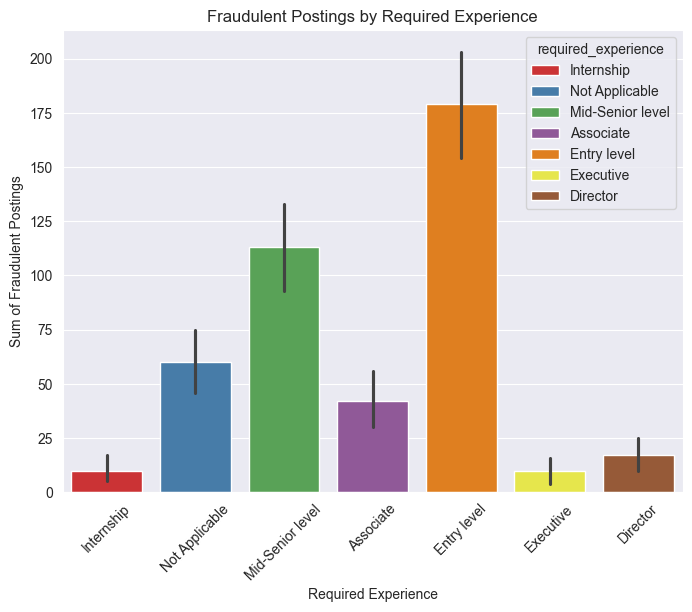

In [46]:
# Bar plot for required_experience
plt.figure(figsize=(8, 6))
sns.barplot(data=df, x='required_experience', y='fraudulent', estimator=sum, hue='required_experience', dodge=False, palette='Set1')
plt.title('Fraudulent Postings by Required Experience')
plt.xlabel('Required Experience')
plt.ylabel('Sum of Fraudulent Postings')
plt.xticks(rotation=45)
plt.show()

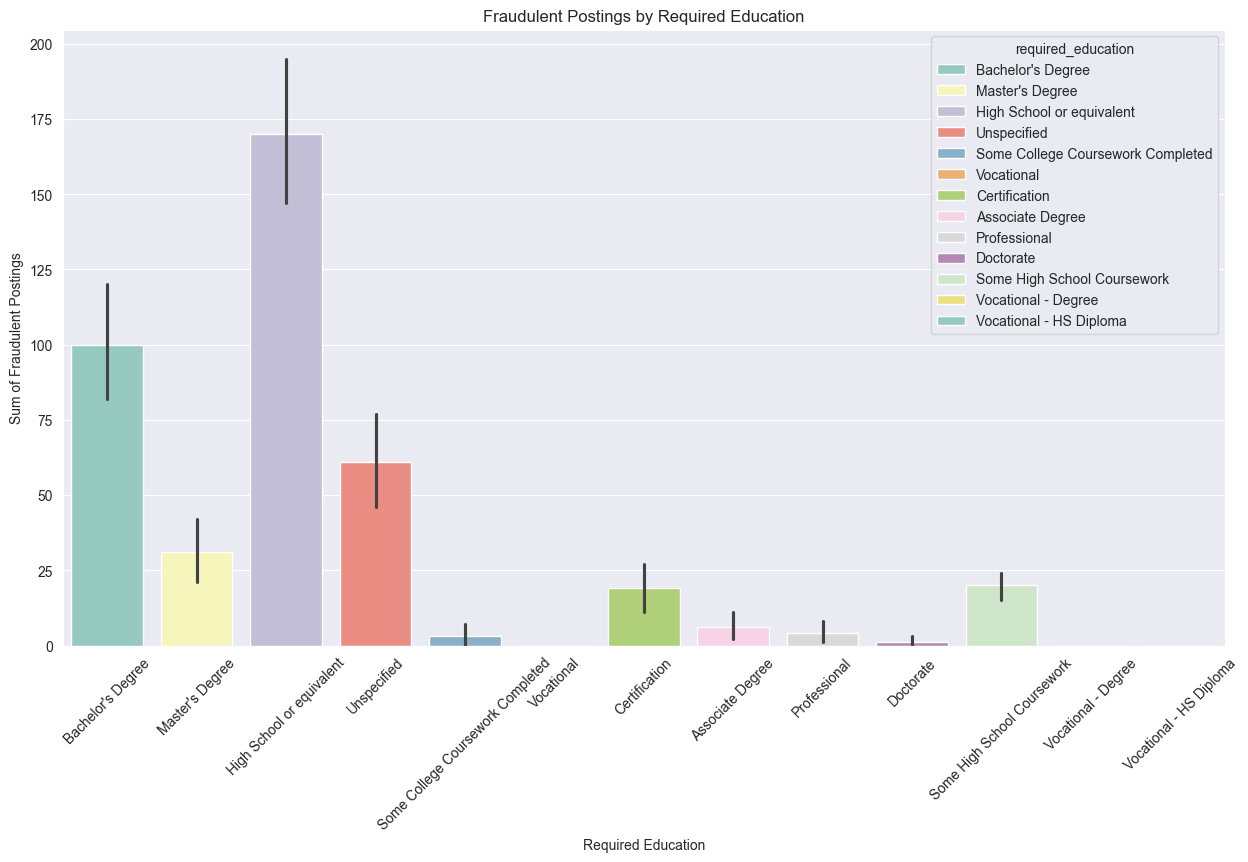

In [47]:
# Bar plot for required_education
plt.figure(figsize=(15, 8))
sns.barplot(data=df, x='required_education', y='fraudulent', estimator=sum, hue='required_education', dodge=False, palette='Set3')
plt.title('Fraudulent Postings by Required Education')
plt.xlabel('Required Education')
plt.ylabel('Sum of Fraudulent Postings')
plt.xticks(rotation=45)
plt.show()

### c. Data Preprocessing

In [48]:
# Select features
df_selected = select_features(df)

# Prepare initial features
df_processed = prepare_initial_features(df_selected)

# Create feature stores
structured_features, label_encoders = create_structured_features(df_processed)
text_features = create_text_features(df_processed)

Processing title...
Processing description...
Processing requirements...
Processing company_profile...
Processing benefits...
Label encoding location...
Label encoding employment_type...
Label encoding required_experience...
Label encoding required_education...
Label encoding industry...
Label encoding function...


In [49]:
print_feature_summary(structured_features, text_features)


Feature Stores Summary:
Structured Features Shape: (17880, 31)
Number of structured features: 31

Structured features include:
- Label encoded categorical features: 6
- Binary features: 4
- Frequency encoded features: 6
- Text length features: 5

Text Features Shape: (17880, 5)
Text features include: ['title_cleaned', 'description_cleaned', 'requirements_cleaned', 'company_profile_cleaned', 'benefits_cleaned']


In [50]:
# Subset target variable
target_features = df[['fraudulent']]

In [51]:
# Add PK column 
for df in [structured_features, text_features, target_features]:
        if 'job_id' in df.columns:
            df.drop(columns=['job_id'], inplace=True)
    
    # Add incremental job_id as the first column
structured_features.insert(0, 'job_id', range(1, len(structured_features) + 1))
text_features.insert(0, 'job_id', range(1, len(text_features) + 1))
target_features.insert(0, 'job_id', range(1, len(target_features) + 1))

In [52]:
# Add an event_timestamp column with today's timestamp
structured_features['event_timestamp'] = pd.Timestamp.now()
text_features['event_timestamp'] = pd.Timestamp.now()
target_features['event_timestamp'] = pd.Timestamp.now()

In [53]:
columns_to_convert = [
    "title_cleaned",
    "description_cleaned",
    "requirements_cleaned",
    "company_profile_cleaned",
    "benefits_cleaned"
]

text_features[columns_to_convert] = text_features[columns_to_convert].astype("string")

In [54]:
text_features.head()

,job_id,title_cleaned,description_cleaned,requirements_cleaned,company_profile_cleaned,benefits_cleaned,event_timestamp
0,1,marketing intern,food52 fast grow james beard award win online ...,experience content management system major plu...,food52 create groundbreaking award win cook si...,,2024-12-12 10:53:30.632792
1,2,customer service cloud video production,organise focused vibrant awesome passion custo...,expect key responsibility communicate client 9...,90 second world cloud video production service...,get usthrough part 90 second team gain experie...,2024-12-12 10:53:30.632792
2,3,commission machinery assistant cma,client locate houston actively seek experience...,implement pre commission commission procedure ...,valor service provide workforce solution meet ...,,2024-12-12 10:53:30.632792
3,4,account executive washington dc,company esri environmental system research ins...,education bachelor master gis business adminis...,passion improve quality life geography heart e...,culture anything corporate collaborative creat...,2024-12-12 10:53:30.632792
4,5,bill review manager,job title itemization review managerlocation f...,qualification rn license state texasdiploma ba...,spotsource solution llc global human capital m...,full benefit offer,2024-12-12 10:53:30.632792


In [55]:
structured_features.head()

,job_id,location,employment_type,required_experience,required_education,industry,function,telecommuting,has_company_logo,has_questions,...,required_experience_is_missing,required_education_is_missing,industry_is_missing,function_is_missing,title_length,description_length,requirements_length,company_profile_length,benefits_length,event_timestamp
0,1,2535,3,4,6,123,22,0,1,0,...,0,1,1,0,16,659,636,610,0,2024-12-12 10:53:30.628454
1,2,1073,1,6,6,75,7,0,1,0,...,0,1,0,0,39,1449,1077,730,782,2024-12-12 10:53:30.628454
2,3,1867,2,7,6,123,36,0,1,0,...,1,1,1,1,34,257,1049,574,0,2024-12-12 10:53:30.628454
3,4,1703,1,5,1,22,31,0,1,0,...,0,0,0,0,31,2017,1155,457,665,2024-12-12 10:53:30.628454
4,5,1741,1,5,1,51,16,0,1,1,...,0,0,0,0,19,1161,642,1348,18,2024-12-12 10:53:30.628454


In [56]:
target_features.head()

,job_id,fraudulent,event_timestamp
0,1,0,2024-12-12 10:53:30.633372
1,2,0,2024-12-12 10:53:30.633372
2,3,0,2024-12-12 10:53:30.633372
3,4,0,2024-12-12 10:53:30.633372
4,5,0,2024-12-12 10:53:30.633372


## 3. Feature Stores

### A. Structured Feature Store

The structured feature store contains processed numerical and categorical features. These features are ready for use in traditional machine learning models.

#### **(1) Label Encoded Categorical Features**
These categorical features have been converted to numerical values using label encoding:
- `location`: Job locations (e.g., "US, NY" → 1, "UK, London" → 2)
- `employment_type`: Job types (e.g., "Full-time" → 0, "Part-time" → 1)
- `required_experience`: Experience levels (e.g., "Entry Level" → 0, "Senior" → 1)
- `required_education`: Education requirements (e.g., "Bachelor's" → 0, "Master's" → 1)
- `industry`: Company industries (e.g., "Technology" → 0, "Healthcare" → 1)
- `function`: Job functions (e.g., "Engineering" → 0, "Sales" → 1)

#### **(2) Binary Features**
Simple 0/1 indicators:
- `telecommuting`: Remote work indicator (1=yes, 0=no)
- `has_company_logo`: Company logo presence (1=yes, 0=no)
- `has_questions`: Screening questions presence (1=yes, 0=no)
- `no_logo_no_questions`: Combined feature (1=no logo & no questions, 0=otherwise)

### **(3) Frequency Encoded Features**
Represents how common each category is in the dataset:
- `location_freq`: Location frequency (e.g., 0.25 = appears in 25% of postings)
- `employment_type_freq`: Employment type frequency
- `required_experience_freq`: Experience level frequency
- `required_education_freq`: Education requirement frequency
- `industry_freq`: Industry frequency
- `function_freq`: Job function frequency

### **(4) Text Length Features**
Character counts of cleaned text fields:
- `title_length`: Job title length
- `description_length`: Job description length
- `requirements_length`: Requirements text length
- `company_profile_length`: Company profile length
- `benefits_length`: Benefits text length

### **(5) Missing Value Indicators**
Binary flags (0/1) indicating missing values in original data:
- Various columns ending with `_is_missing`

## B. Text Feature Store

The text feature store contains cleaned and processed text data, ready for natural language processing tasks.

### **(1) Cleaned Text Features**
Each text field has been processed to remove noise and standardize format:

- `title_cleaned`
  - Original: "Senior Software Engineer (Python/Django)"
  - Cleaned: "senior software engineer python django"

- `description_cleaned`
  - Original: "We are looking for a talented Software Engineer..."
  - Cleaned: "looking talented software engineer..."

- `requirements_cleaned`
  - Original: "5+ years of Python experience required"
  - Cleaned: "years python experience required"

- `company_profile_cleaned`
  - Original: "We're a fast-growing tech company..."
  - Cleaned: "fast growing tech company"

- `benefits_cleaned`
  - Original: "401(k), Health Insurance, Flexible Hours"
  - Cleaned: "health insurance flexible hours"

## C. Target Feature Store

The target feature store only contains target variable 'fraudulent'

### a. Initialize the Feast repo called job repo to current directory & Save data to directory

In [57]:
!feast init -m job_repo


Creating a new Feast repository in /Users/devondelgado/mlops-final-project/job_repo.



In [58]:
# Save features
save_features(structured_features, text_features, target_features)

### b. Define feature stores and schema for job_repo

In [59]:
# Update feature_store.yaml
feature_store_yaml_content = """
project: job_project
registry: data/registry.db
provider: local
online_store:
    type: sqlite
    path: data/online_store.db
offline_store:
    type: file
entity_key_serialization_version: 2
"""

# Write the content to feature_store.yaml
with open('job_repo/feature_repo/feature_store.yaml', 'w') as f:
    f.write(feature_store_yaml_content.strip())

print("Updated feature_store.yaml")

Updated feature_store.yaml


### c. Create features.py

In [60]:
# Create features.py file
features_py_content = '''
from datetime import timedelta
from feast import Entity, FeatureView, Field, FileSource, Project
from feast.types import Float32, String, Int64

# Define a project for the feature repo
project = Project(name="job_project", description="A project for job data")

# Define the entity
job = Entity(
    name="job_id",
    join_keys=["job_id"],
    description="Unique identifier for job",
)

# Define the Structured Feature data source
job_structured_data_source = FileSource(
    name='job_structured_data',
    path="data/structured_features.parquet",
    timestamp_field="event_timestamp")

# Define the Structured Feature
job_structured_features = FeatureView(
    name="job_structured_features_view",
    entities=[job],
    ttl=timedelta(days=1),
    schema=[
        Field(name="location", dtype=Int64),
        Field(name="employment_type", dtype=Int64),
        Field(name="required_experience", dtype=Int64),
        Field(name="required_education", dtype=Int64),
        Field(name="industry", dtype=Int64),
        Field(name="function", dtype=Int64),
        Field(name="telecommuting", dtype=Int64),
        Field(name="has_company_logo", dtype=Int64),
        Field(name="has_questions", dtype=Int64),
        Field(name="no_logo_no_questions", dtype=Int64),
        Field(name="location_freq", dtype=Float32),
        Field(name="employment_type_freq", dtype=Float32),
        Field(name="required_experience_freq", dtype=Float32),
        Field(name="required_education_freq", dtype=Float32),
        Field(name="industry_freq", dtype=Float32),
        Field(name="function_freq", dtype=Float32),
        Field(name="description_is_missing", dtype=Int64),
        Field(name="requirements_is_missing", dtype=Int64),
        Field(name="company_profile_is_missing", dtype=Int64),
        Field(name="benefits_is_missing", dtype=Int64),
        Field(name="location_is_missing", dtype=Int64),
        Field(name="employment_type_is_missing", dtype=Int64),
        Field(name="required_experience_is_missing", dtype=Int64),
        Field(name="required_education_is_missing", dtype=Int64),
        Field(name="industry_is_missing", dtype=Int64),
        Field(name="function_is_missing", dtype=Int64),
        Field(name="title_length", dtype=Int64),
        Field(name="description_length", dtype=Int64),
        Field(name="requirements_length", dtype=Int64),
        Field(name="company_profile_length", dtype=Int64),
        Field(name="benefits_length", dtype=Int64),
    ],
    online=True,
    source=job_structured_data_source,
)

# Define the Text Features data source
job_text_data_source  = FileSource(
    name='job_text_data',
    path="data/text_features.parquet",
    timestamp_field="event_timestamp" )

# Define the predictor Feature View
job_text_features = FeatureView(
    name="job_text_features_view",
    entities=[job], 
    ttl=timedelta(days=1),
    schema=[
        Field(name="title_cleaned", dtype=String),
        Field(name="description_cleaned", dtype=String),
        Field(name="requirements_cleaned", dtype=String),
        Field(name="company_profile_cleaned", dtype=String),
        Field(name="benefits_cleaned", dtype=String)
    ],
    online=True,
    source=job_text_data_source,
)

# Define the target data source
job_target_source = FileSource(
    name='job_target',
    path="data/target_features.parquet",
    timestamp_field="event_timestamp")

# Define the target Feature View with all columns
job_target_features = FeatureView(
    name="job_target_feature_view",
    entities=[job],
    ttl=timedelta(days=1),
    schema=[
        Field(name="fraudulent", dtype=Int64),
    ],
    online=True,
    source=job_target_source,
)
'''

# Write the content to features.py
with open('job_repo/feature_repo/features.py', 'w') as f:
    f.write(features_py_content.strip())

print("Created features.py")

Created features.py


### c. feast apply

In [ ]:
!cd job_repo/feature_repo && feast apply

### d. Extract features from feature stores

In [61]:
# Set the store
store = FeatureStore('job_repo/feature_repo')

In [62]:
from datetime import datetime
# Simulate the scenario we want a bunch of 'job_id' that created recently
today = pd.Timestamp(datetime.now().date()) 
entity_df = target_features[target_features['event_timestamp'] >= today][['job_id', 'event_timestamp']]

In [63]:
# Retrieve predictors and target from different features view
training_data = store.get_historical_features(
    entity_df=entity_df,
    features=[
        "job_structured_features_view:location",
        "job_structured_features_view:employment_type",
        "job_structured_features_view:required_experience",
        "job_structured_features_view:required_education",
        "job_structured_features_view:industry",
        "job_structured_features_view:function",
        "job_structured_features_view:telecommuting",
        "job_structured_features_view:has_company_logo",
        "job_structured_features_view:has_questions",
        "job_structured_features_view:no_logo_no_questions",
        "job_structured_features_view:location_freq",
        "job_structured_features_view:employment_type_freq",
        "job_structured_features_view:required_experience_freq",
        "job_structured_features_view:required_education_freq",
        "job_structured_features_view:industry_freq",
        "job_structured_features_view:function_freq",
        "job_structured_features_view:description_is_missing",
        "job_structured_features_view:requirements_is_missing",
        "job_structured_features_view:company_profile_is_missing",
        "job_structured_features_view:benefits_is_missing",
        "job_structured_features_view:location_is_missing",
        "job_structured_features_view:employment_type_is_missing",
        "job_structured_features_view:required_experience_is_missing",
        "job_structured_features_view:required_education_is_missing",
        "job_structured_features_view:industry_is_missing",
        "job_structured_features_view:function_is_missing",
        "job_structured_features_view:title_length",
        "job_structured_features_view:description_length",
        "job_structured_features_view:requirements_length",
        "job_structured_features_view:company_profile_length",
        "job_structured_features_view:benefits_length",
        "job_text_features_view:title_cleaned",
        "job_text_features_view:description_cleaned",
        "job_text_features_view:requirements_cleaned",
        "job_text_features_view:company_profile_cleaned",
        "job_text_features_view:benefits_cleaned",
        "job_target_feature_view:fraudulent"
    ]
)


# Convert to DataFrame for inspection
training_data_df = training_data.to_df()

In [64]:
# Dropping the columns 'job_id' and 'event_timestamp' from training_data_df
training_data_df = training_data_df.drop(columns=['job_id', 'event_timestamp'])

In [65]:
training_data_df.head()

,location,employment_type,required_experience,required_education,industry,function,telecommuting,has_company_logo,has_questions,no_logo_no_questions,...,description_length,requirements_length,company_profile_length,benefits_length,title_cleaned,description_cleaned,requirements_cleaned,company_profile_cleaned,benefits_cleaned,fraudulent
0,2535,3,4,6,123,22,0,1,0,0,...,659,636,610,0,marketing intern,food52 fast grow james beard award win online ...,experience content management system major plu...,food52 create groundbreaking award win cook si...,,0
1,1954,4,6,4,61,7,1,1,1,0,...,594,244,300,63,online auction manager,shop ship international shipping service offer...,clear background record work permit we high sc...,world ship one international shipping service ...,2 800 per month pay biweekly expense reimburse...,0
2,1060,1,5,6,123,25,0,1,0,0,...,1301,0,883,0,post producer,postproduction pundit mediamonk look hire prof...,,mediamonk big creative digital production comp...,,0
3,1133,1,7,1,118,29,0,1,0,0,...,338,0,605,0,quality assurance assistant,requirement candidate must possess least bache...,,zylun mission help small medium size enterpris...,,0
4,793,1,5,1,61,12,0,1,1,0,...,996,342,558,357,frontend developer,incrediblue bust myth boat rich famous enable ...,mastery html5 css javascript experience front ...,incrediblue bust myth boat rich famous enable ...,benefit include apple workstationsoftware tool...,0


## 4. Data Post-processing (We don't want to create 500 columns in feature store since it's a simulated project. Hence, we do the text-processing over here)

### a. Combined text features

In [66]:
# Combine Text Features
text_columns = ['title_cleaned', 'company_profile_cleaned', 'description_cleaned', 'requirements_cleaned', 'benefits_cleaned']
training_data_df['cleaned_combined_text'] = training_data_df[text_columns].agg(' '.join, axis=1)

In [67]:
training_data_df= training_data_df.drop(columns=text_columns)

In [68]:
training_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 33 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   location                        17880 non-null  int64  
 1   employment_type                 17880 non-null  int64  
 2   required_experience             17880 non-null  int64  
 3   required_education              17880 non-null  int64  
 4   industry                        17880 non-null  int64  
 5   function                        17880 non-null  int64  
 6   telecommuting                   17880 non-null  int64  
 7   has_company_logo                17880 non-null  int64  
 8   has_questions                   17880 non-null  int64  
 9   no_logo_no_questions            17880 non-null  int64  
 10  location_freq                   17880 non-null  float64
 11  employment_type_freq            17880 non-null  float64
 12  required_experience_freq        

### b. TfidfVectorizer

In [69]:
# Initialize the vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

X_tfidf = tfidf_vectorizer.fit_transform(training_data_df['cleaned_combined_text'])

# Feature names
feature_names = tfidf_vectorizer.get_feature_names_out()

# Convert to DataFrame (optional)
tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=feature_names)

In [70]:
tfidf_df.shape

(17880, 5000)

In [71]:
# SVD to reduce dimensionality
svd = TruncatedSVD(n_components=500)  
X_tfidf_reduced = svd.fit_transform(X_tfidf)
tfidf_df_reduced = pd.DataFrame(X_tfidf_reduced, columns=[f'svd_{i}' for i in range(500)])

In [72]:
training_data_df = training_data_df.drop(columns=['cleaned_combined_text'])

In [73]:
training_data_with_tfidf = pd.concat([training_data_df.reset_index(drop=True), tfidf_df_reduced], axis=1)

In [74]:
training_data_with_tfidf.head()

,location,employment_type,required_experience,required_education,industry,function,telecommuting,has_company_logo,has_questions,no_logo_no_questions,...,svd_490,svd_491,svd_492,svd_493,svd_494,svd_495,svd_496,svd_497,svd_498,svd_499
0,2535,3,4,6,123,22,0,1,0,0,...,-0.009988,0.022839,0.033235,-0.038594,-0.008713,-0.001881,-0.015039,-0.004992,-0.012269,0.017220
1,1954,4,6,4,61,7,1,1,1,0,...,-0.107630,-0.001641,-0.043049,-0.068843,-0.017068,-0.017055,0.005448,-0.007692,-0.027410,0.002237
2,1060,1,5,6,123,25,0,1,0,0,...,0.009599,0.004356,-0.006733,-0.012664,0.004167,0.006139,0.009489,-0.010365,-0.022156,-0.000989
3,1133,1,7,1,118,29,0,1,0,0,...,0.015926,0.046383,0.015656,-0.017664,0.004236,-0.002258,0.015761,-0.001953,-0.000425,0.018661
4,793,1,5,1,61,12,0,1,1,0,...,0.004642,0.012506,0.003510,-0.003052,-0.001891,0.005770,0.012555,-0.001777,0.007707,0.016957


In [75]:
# Save DataFrame to Parquet for temporary usage
training_data_with_tfidf.to_parquet("training_data_with_tfidf.parquet", index=False)

## 5. Model Building

The target for this dataset is 'fraudulent', which is a binary variable of 0 or 1 to indicate if the listing is fraudulent or not (0 for not, 1 for is fraudulent). AUC-Precision-Recall will be used as the metric for best performance as it provides the best balance of the business problem: We want people to be safe from applying to fake jobs as they risk their information getting leaked or scammed, and at the same time want people to have trust in the system so that legitimate jobs don't get flagged as spam. F1-Score was not available as a metric for H2O to rank models.

Run `mlflow ui` in the terminal and go to http://127.0.0.1:5000 to look at the logged runs.

In [1]:
from mlflow_runner import run_mlflow_pipeline

run_mlflow_pipeline('training_data_with_tfidf.parquet')

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_371"; Java(TM) SE Runtime Environment (build 1.8.0_371-b11); Java HotSpot(TM) 64-Bit Server VM (build 25.371-b11, mixed mode)
  Starting server from /Users/devondelgado/miniconda3/envs/mlops/lib/python3.10/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/b4/nhbrf4ws253b52n__dgvd0gr0000gn/T/tmp0f7g8lle
  JVM stdout: /var/folders/b4/nhbrf4ws253b52n__dgvd0gr0000gn/T/tmp0f7g8lle/h2o_devondelgado_started_from_python.out
  JVM stderr: /var/folders/b4/nhbrf4ws253b52n__dgvd0gr0000gn/T/tmp0f7g8lle/h2o_devondelgado_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,America/Chicago
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.6
H2O_cluster_version_age:,23 days
H2O_cluster_name:,H2O_from_python_devondelgado_s1uc18
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.541 Gb
H2O_cluster_total_cores:,10
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
15:34:12.150: _train param, Dropping bad and constant columns: [description_is_missing]

██
15:36:26.830: _train param, Dropping bad and constant columns: [description_is_missing]

████████████████████
15:38:30.871: _train param, Dropping bad and constant columns: [description_is_missing]

██
15:39:09.629: _train param, Dropping bad and constant columns: [description_is_missing]

█████████████
15:41:18.21: _train param, Dropping bad and constant columns: [description_is_missing]

██
15:42:04.306: _train param, Dropping bad and constant columns: [description_is_missing]

████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
🏃 View run Leader_Model_Run at: http://127.0.0.1:5000/#/experiments/0/runs/a5b53a765cd0473eaf77639274dd5a6d
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0
xgboost 

## 6. Model Deployment

We utilized MLflow model serve to deploy the model locally, and with combination of MLflow and Evidently, we are able to monitor the data drift and validate the results metrics. 

Run `mlflow ui` in the terminal and go to http://127.0.0.1:5000 to look at the data model monitor and data drift report.

### Load the model

In [29]:
import os
import json
import requests
import pandas as pd
import h2o
import mlflow
import mlflow.h2o
import mlflow.pyfunc
from mlflow.tracking import MlflowClient
from sklearn.metrics import accuracy_score, classification_report
from evidently.report import Report
from evidently import ColumnMapping
from evidently.metric_preset import DataDriftPreset, ClassificationPreset

In [32]:
mlflow.set_tracking_uri("http://127.0.0.1:5000")

In [33]:
# Initialize H2O
h2o.init()

# Path to the H2O model
local_model_path = "mlartifacts/0/a5b53a765cd0473eaf77639274dd5a6d/artifacts/Leader/model.h2o/XGBoost_3_AutoML_1_20241125_153411"

# Load the model
absolute_path = os.path.abspath(local_model_path)
model = h2o.load_model(absolute_path)

# model = h2o.load_model(local_model_path)

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,1 day 20 hours 30 mins
H2O_cluster_timezone:,America/Chicago
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.6
H2O_cluster_version_age:,1 month and 9 days
H2O_cluster_name:,H2O_from_python_xxb_h3cjgq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.286 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


### Serve the Model Locally

In [10]:
# run in the bash
# mlflow models serve \
#     -m "mlartifacts/0/a5b53a765cd0473eaf77639274dd5a6d/artifacts/Leader" \
#     --host 127.0.0.1 --port 5001 \
#     --env-manager conda

### Validate the Deployed Model

In [36]:
# Load test data
test_data = pd.read_csv("mlartifacts/0/a5b53a765cd0473eaf77639274dd5a6d/artifacts/test_data/test_set.csv")

# Extract true labels
true_labels = test_data["fraudulent"]

# Prepare the payload for prediction
payload = {
    "dataframe_split": test_data.to_dict(orient="split")  
}

# Send POST request to the model
response = requests.post(
    url="http://127.0.0.1:5001/invocations",
    json=payload
)

# Extract predictions
predictions = [pred["predict"] for pred in response.json()["predictions"]]

# Compute and print accuracy
accuracy = accuracy_score(true_labels[:len(predictions)], predictions)
print(f"Accuracy: {accuracy}")

# Compute and print detailed metrics
print("Classification Report:")
print(classification_report(true_labels[:len(predictions)], predictions))

Accuracy: 0.9751570531125071
Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      3334
           1       1.00      0.48      0.65       168

    accuracy                           0.98      3502
   macro avg       0.99      0.74      0.82      3502
weighted avg       0.98      0.98      0.97      3502



In [37]:
# Attach predictions to test data
original_data = test_data.copy()
original_data["predict"] = predictions

### Testing with Modified Inputs

In [38]:
# Create a copy of the test data
altered_test_data = test_data.copy()

# Modify features in the test data
altered_test_data["description_length"] = altered_test_data["description_length"] / 2  # Shorten descriptions
altered_test_data["location"] = 0  # Set an invalid location
altered_test_data["required_experience"] = 0  # Set missing experience

# Prepare the payload for the altered data in 'dataframe_split' format
altered_payload = {
    "dataframe_split": altered_test_data.to_dict(orient="split")
}

# Send POST request to the model with altered data
altered_response = requests.post(
    url="http://127.0.0.1:5001/invocations",
    json=altered_payload
)

# Check if the response includes predictions and probabilities
if "predictions" in altered_response.json():
    # Extract predictions (with probabilities) from the response
    altered_predictions = altered_response.json()["predictions"]

    # Print predictions with probabilities
    for pred in altered_predictions[:5]:  # Print only the first 5 for brevity
        print(f"Prediction: {pred['predict']}, p0: {pred['p0']}, p1: {pred['p1']}")

    # Save predictions back to the altered test data
    altered_test_data["predict"] = [pred["predict"] for pred in altered_predictions]
    altered_test_data["p0"] = [pred["p0"] for pred in altered_predictions]
    altered_test_data["p1"] = [pred["p1"] for pred in altered_predictions]

    # Save the altered test data with predictions
    altered_test_data.to_csv("altered_test_data_with_predictions.csv", index=False)

    print("Altered test data with predictions saved to 'altered_test_data_with_predictions.csv'.")
else:
    print("Error: No 'predictions' found in the response.")

Prediction: 0, p0: 0.9995294213294984, p1: 0.00047056618495844305
Prediction: 0, p0: 0.996865689754486, p1: 0.003134339582175
Prediction: 0, p0: 0.9800410866737366, p1: 0.0199589394032955
Prediction: 0, p0: 0.9998998045921326, p1: 0.00010018172906711698
Prediction: 0, p0: 0.999268114566803, p1: 0.0007318663410842419
Altered test data with predictions saved to 'altered_test_data_with_predictions.csv'.


In [39]:
# Extract only the predicted classes from altered_predictions
altered_predicted_classes = [pred["predict"] for pred in altered_predictions]

# Calculate accuracy for the altered data
altered_accuracy = accuracy_score(true_labels[:len(altered_predicted_classes)], altered_predicted_classes)

# Print comparison of accuracies
print(f"Original Accuracy: {accuracy}")
print(f"Altered Accuracy: {altered_accuracy}")

# Generate and print classification reports
print("Original Data Metrics:")
print(classification_report(true_labels[:len(predictions)], predictions))

print("Altered Data Metrics:")
print(classification_report(true_labels[:len(altered_predicted_classes)], altered_predicted_classes))

Original Accuracy: 0.9751570531125071
Altered Accuracy: 0.9674471730439749
Original Data Metrics:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      3334
           1       1.00      0.48      0.65       168

    accuracy                           0.98      3502
   macro avg       0.99      0.74      0.82      3502
weighted avg       0.98      0.98      0.97      3502

Altered Data Metrics:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      3334
           1       1.00      0.32      0.49       168

    accuracy                           0.97      3502
   macro avg       0.98      0.66      0.73      3502
weighted avg       0.97      0.97      0.96      3502



### Track Model Metrics in MLflow and Evidently

In [41]:
# Define ColumnMapping for classification and data drift
column_mapping = ColumnMapping(
    target="fraudulent",              # Target variable
    prediction="predict",             # Model predictions
    numerical_features=[
        "location_freq", "employment_type_freq", "required_experience_freq",
        "required_education_freq", "industry_freq", "function_freq",
        "description_length", "title_length", "requirements_length",
        "company_profile_length", "benefits_length"
    ] + [f"svd_{i}" for i in range(500)],  # Include all SVD columns
    categorical_features=[
        "location", "employment_type", "required_experience", 
        "required_education", "industry", "function", 
        "telecommuting", "has_company_logo", "has_questions", 
        "no_logo_no_questions", "description_is_missing", "requirements_is_missing",
        "company_profile_is_missing", "benefits_is_missing", "location_is_missing", 
        "employment_type_is_missing", "required_experience_is_missing", 
        "required_education_is_missing", "industry_is_missing", 
        "function_is_missing"
    ]
)

#### Original Test Data Monitor

In [44]:
# Calculate original metrics
original_accuracy = accuracy_score(test_data["fraudulent"], predictions)
original_report = classification_report(test_data["fraudulent"], predictions, output_dict=True)

# Start MLflow run for logging original metrics
with mlflow.start_run():
    # Log metrics
    mlflow.log_metrics({
        "Original Accuracy": original_accuracy,
        "Original Precision": original_report["1"]["precision"],
        "Original Recall": original_report["1"]["recall"],
        "Original F1-Score": original_report["1"]["f1-score"],
    })

    # Log dataset
    test_data_file = os.path.join(os.getcwd(), "test_data.csv")
    test_data.to_csv(test_data_file, index=False)
    mlflow.log_artifact(test_data_file)

    # Save and log classification report
    classification_report_file = os.path.join(os.getcwd(), "original_classification_report.json")
    with open(classification_report_file, "w") as f:
        json.dump(original_report, f)
    mlflow.log_artifact(classification_report_file)

    # Create and log Evidently report
    report = Report(metrics=[DataDriftPreset(), ClassificationPreset()])
    report.run(reference_data=original_data, current_data=original_data, column_mapping=column_mapping)
    # Save and log Evidently HTML report
    report_path = "evidently_report.html"
    report.save_html(report_path)
    mlflow.log_artifact(report_path)

    print("Original metrics and artifacts logged to MLflow.")

#### Altered Data Drift Monitor

In [45]:
# Ensure fraudulent column contains only 0 and 1
altered_test_data = altered_test_data[altered_test_data["fraudulent"].isin([0, 1])]

# Align lengths if necessary
altered_test_data = altered_test_data.iloc[:len(altered_predicted_classes)]

# Calculate metrics for original and altered data
original_accuracy = accuracy_score(test_data["fraudulent"], predictions)
altered_accuracy = accuracy_score(altered_test_data["fraudulent"], altered_predicted_classes)

# Generate classification reports
original_report = classification_report(test_data["fraudulent"], predictions, output_dict=True)
altered_report = classification_report(altered_test_data["fraudulent"], altered_predicted_classes, output_dict=True)

def log_evidently_to_mlflow(reference_data, current_data, column_mapping, experiment_name="Monitoring with EvidentlyAI"):
    # Set MLflow experiment
    #log into MLflow
    client = MlflowClient()

    #set experiment
    mlflow.set_experiment('Monitoring with EvidentlyAI')
    
    # Ensure the `predict` column exists and has no missing values
    for dataset, name in [(reference_data, "Reference Data"), (current_data, "Current Data")]:
        if "predict" not in dataset.columns:
            raise ValueError(f"`predict` column is missing in {name}. Please add predictions.")
        if dataset["predict"].isna().any():
            raise ValueError(f"`predict` column in {name} contains missing values. Fill or generate predictions.")
    
    reference_data["predict"].fillna(-1, inplace=True)
    current_data["predict"].fillna(-1, inplace=True)
    
    with mlflow.start_run():
        # Log accuracy metrics
        mlflow.log_metrics({
            "Original Accuracy": original_accuracy,
            "Altered Accuracy": altered_accuracy,
        })

        # Log classification metrics for class '1'
        mlflow.log_metrics({
            "Original Precision": original_report["1"]["precision"],
            "Original Recall": original_report["1"]["recall"],
            "Original F1-Score": original_report["1"]["f1-score"],
            "Altered Precision": altered_report["1"]["precision"],
            "Altered Recall": altered_report["1"]["recall"],
            "Altered F1-Score": altered_report["1"]["f1-score"],
        })

        # Save and log datasets
        for file_name, data in zip(["test_data.csv", "altered_test_data.csv"], [test_data, altered_test_data]):
            data.to_csv(file_name, index=False)
            mlflow.log_artifact(file_name)

        # Save and log classification reports as JSON
        import json
        for file_name, report in zip(["original_report.json", "altered_report.json"], [original_report, altered_report]):
            with open(file_name, "w") as f:
                json.dump(report, f)
            mlflow.log_artifact(file_name)

        # Create and log Evidently report
        report = Report(metrics=[DataDriftPreset(), ClassificationPreset()])
        report.run(reference_data=reference_data, current_data=current_data, column_mapping=column_mapping)
        
        # Save and log Evidently HTML report
        report_path = "evidently_report.html"
        report.save_html(report_path)
        mlflow.log_artifact(report_path)

        print("Metrics and Evidently report logged to MLflow.")

In [46]:
log_evidently_to_mlflow(reference_data=original_data, current_data=altered_test_data, column_mapping=column_mapping)